In [1]:
import tensorflow as tf
from tensorflow import keras
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import imghdr

Спочатку в окремому перевіримо, щоб всі файли були формату `jpeg`, бо насправді в початковому ні! (треба розкоментувати цю частину, якщо дійсно треба, бо я вже зробив)

In [2]:
def validate_that_photos_are_indeed_photos(data_dir, move_to):
    image_extensions = [".jpg"]
    destination_folder = pathlib.Path(move_to)

    img_type_accepted_by_tf = ["jpeg"]
    for filepath in pathlib.Path(data_dir).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
                filepath.replace(destination_folder / filepath.name)
            elif img_type not in img_type_accepted_by_tf:
                print(
                    f"{filepath} is a {img_type}, not accepted by TensorFlow"
                )
                filepath.replace(destination_folder / filepath.name)


data_dir = r"E:\Homework\ІСППР\PetImages\Dog"
move_to = r"E:\Homework\ІСППР\PetImages\Dog_"
# validate_that_photos_are_indeed_photos(data_dir, move_to)

data_dir = r"E:\Homework\ІСППР\PetImages\Cat"
move_to = r"E:\Homework\ІСППР\PetImages\Cat__"
# validate_that_photos_are_indeed_photos(data_dir, move_to)


In [3]:
path_cat = pathlib.Path(r"E:\Homework\ІСППР\PetImages\Cat")
cat_list = sorted([str(path) for path in
                    path_cat.glob('*.jpg')][:])
path_dog = pathlib.Path(r"E:\Homework\ІСППР\PetImages\Dog")
dog_list = sorted([str(path) for path in
                    path_dog.glob('*.jpg')][:])

In [4]:
len(dog_list), len(cat_list)

(12349, 12385)

In [5]:
ratio = 0.8
dog_int = int(len(dog_list)*ratio)
cat_int = int(len(cat_list)*ratio)

photos_train = tf.data.Dataset.from_tensor_slices(
    dog_list[:dog_int] + cat_list[:cat_int])
y_train = tf.data.Dataset.from_tensor_slices([np.array([0.0, 1], dtype=np.float32) for _ in dog_list[:dog_int]] +
                                             [np.array([1.0, 0], dtype=np.float32) for _ in cat_list[:cat_int]])


photos_test = tf.data.Dataset.from_tensor_slices(
    dog_list[dog_int:] + cat_list[cat_int:])
y_test = tf.data.Dataset.from_tensor_slices([np.array([0.0, 1], dtype=np.float32) for _ in dog_list[dog_int:]] +
                                            [np.array([1.0, 0], dtype=np.float32) for _ in cat_list[cat_int:]])


In [6]:
img_width, img_height = 50, 50

def load_and_preprocess(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image /= 255.0
    return image

x_train = photos_train.map(load_and_preprocess)

x_test = photos_test.map(load_and_preprocess)

In [7]:
x_train = np.array([i.numpy() for i in x_train])
x_test = np.array([i.numpy() for i in x_test])
y_train = np.array([i.numpy() for i in y_train])
y_test = np.array([i.numpy() for i in y_test])


In [8]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((19787, 50, 50, 3), (4947, 50, 50, 3), (19787, 2), (4947, 2))

In [9]:
model1 = keras.Sequential()
model1.add(
    keras.layers.Conv2D(32, (3, 3), padding="same",
                        activation="relu", input_shape=(50, 50, 3)))
model1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(keras.layers.Flatten())
model1.add(keras.layers.Dense(2, activation="softmax"))
model1.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])
print(model1.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 2)                 40002     
                                                                 
Total params: 40,898
Trainable params: 40,898
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
model2 = keras.Sequential()
model2.add(
    keras.layers.BatchNormalization(input_shape=(50, 50, 3)),
)
model2.add(
    keras.layers.Conv2D(32, (3, 3), padding="same",
                        activation="relu"))
model2.add(
    keras.layers.Conv2D(32, (3, 3), padding="same",
                        activation="relu"))


model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(keras.layers.Dropout(0.25))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(128, activation="relu"))
model2.add(keras.layers.Dropout(0.5))

model2.add(keras.layers.Dense(2, activation="softmax"))

model2.compile(loss="categorical_crossentropy",
               optimizer="adam", metrics=["accuracy"])
print(model2.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 50, 50, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 20000)            

In [11]:
model3 = keras.Sequential()
model3.add(
    keras.layers.BatchNormalization(input_shape=(50, 50, 3)),
)
model3.add(
    keras.layers.Conv2D(32, (4, 4), padding="same",
                        activation="relu"))
model3.add(
    keras.layers.Conv2D(32, (4, 4), padding="same",
                        activation="relu",))


model3.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(keras.layers.Dropout(0.25))
model3.add(
    keras.layers.Conv2D(32, (4, 4), padding="same",
                        activation="relu"))

model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(128, activation="relu"))
model3.add(keras.layers.Dropout(0.5))
model3.add(keras.layers.Dense(2, activation="softmax"))

model3.compile(loss="categorical_crossentropy",
               optimizer="adam", metrics=["accuracy"])
print(model3.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 50, 50, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        1568      
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        16416     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 25, 25, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 32)       

In [14]:

history1 = model1.fit(
    x_train, y_train,
    batch_size=200, epochs=12,
    validation_split=0.2,
    validation_data=(x_test, y_test),
    verbose=1)

history2 = model2.fit(
    x_train, y_train,
    batch_size=200, epochs=12,
    validation_split=0.2,
    validation_data=(x_test, y_test),
    verbose=1)

history3 = model3.fit(
    x_train, y_train,
    batch_size=200, epochs=12,
    validation_split=0.2,
    validation_data=(x_test, y_test),
    verbose=1)


Epoch 1/12
99/99 [==============================] - 23s 221ms/step - loss: 0.7196 - accuracy: 0.5811 - val_loss: 0.5910 - val_accuracy: 0.7000
Epoch 2/12
99/99 [==============================] - 21s 215ms/step - loss: 0.5678 - accuracy: 0.7113 - val_loss: 0.5365 - val_accuracy: 0.7386
Epoch 3/12
99/99 [==============================] - 21s 215ms/step - loss: 0.5307 - accuracy: 0.7385 - val_loss: 0.5196 - val_accuracy: 0.7522
Epoch 4/12
99/99 [==============================] - 22s 219ms/step - loss: 0.5016 - accuracy: 0.7582 - val_loss: 0.5071 - val_accuracy: 0.7566
Epoch 5/12
99/99 [==============================] - 21s 214ms/step - loss: 0.4848 - accuracy: 0.7698 - val_loss: 0.5058 - val_accuracy: 0.7643
Epoch 6/12
99/99 [==============================] - 21s 213ms/step - loss: 0.4704 - accuracy: 0.7794 - val_loss: 0.4956 - val_accuracy: 0.7641
Epoch 7/12
99/99 [==============================] - 21s 214ms/step - loss: 0.4586 - accuracy: 0.7884 - val_loss: 0.5035 - val_accuracy: 0.7572

In [15]:
model1.save("model1.h5")
model2.save("model2.h5")
model3.save("model3.h5")



Саме `padding`, `strides` та розмірність буду досліджувати на першій моделі окремо, що б не комп'ютер не помер🙂.

In [16]:
model1_1 = keras.Sequential()
model1_1.add(
    keras.layers.Conv2D(32, (3, 3), padding="valid",
                        activation="relu", input_shape=(50, 50, 3)))
model1_1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model1_1.add(keras.layers.Flatten())
model1_1.add(keras.layers.Dense(2, activation="softmax"))
model1_1.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])
print(model1_1.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 dense_5 (Dense)             (None, 2)                 36866     
                                                                 
Total params: 37,762
Trainable params: 37,762
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
model1_2 = keras.Sequential()
model1_2.add(
    keras.layers.Conv2D(32, (2, 4), padding="same",
                        activation="relu", input_shape=(50, 50, 3)))
model1_2.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model1_2.add(keras.layers.Flatten())
model1_2.add(keras.layers.Dense(2, activation="softmax"))
model1_2.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])
print(model1_2.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 50, 50, 32)        800       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 20000)             0         
                                                                 
 dense_6 (Dense)             (None, 2)                 40002     
                                                                 
Total params: 40,802
Trainable params: 40,802
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model1_3 = keras.Sequential()
model1_3.add(
    keras.layers.Conv2D(32, (3, 3), padding="same", strides=(2, 2),
                        activation="relu", input_shape=(50, 50, 3)))
model1_3.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model1_3.add(keras.layers.Flatten())
model1_3.add(keras.layers.Dense(2, activation="softmax"))
model1_3.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])
print(model1_3.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 4608)              0         
                                                                 
 dense_7 (Dense)             (None, 2)                 9218      
                                                                 
Total params: 10,114
Trainable params: 10,114
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
history1_1 = model1_1.fit(
    x_train, y_train,
    batch_size=200, epochs=12,
    validation_split=0.2,
    validation_data=(x_test, y_test),
    verbose=1)

history1_2 = model1_2.fit(
    x_train, y_train,
    batch_size=200, epochs=12,
    validation_split=0.2,
    validation_data=(x_test, y_test),
    verbose=1)

history1_3 = model1_3.fit(
    x_train, y_train,
    batch_size=200, epochs=12,
    validation_split=0.2,
    validation_data=(x_test, y_test),
    verbose=1)



Epoch 1/12
99/99 [==============================] - 21s 199ms/step - loss: 0.6896 - accuracy: 0.6045 - val_loss: 0.5938 - val_accuracy: 0.6899
Epoch 2/12
99/99 [==============================] - 20s 203ms/step - loss: 0.5719 - accuracy: 0.7064 - val_loss: 0.5435 - val_accuracy: 0.7352
Epoch 3/12
99/99 [==============================] - 19s 196ms/step - loss: 0.5317 - accuracy: 0.7408 - val_loss: 0.5192 - val_accuracy: 0.7431
Epoch 4/12
99/99 [==============================] - 20s 204ms/step - loss: 0.5066 - accuracy: 0.7598 - val_loss: 0.5043 - val_accuracy: 0.7588
Epoch 5/12
99/99 [==============================] - 24s 239ms/step - loss: 0.4832 - accuracy: 0.7749 - val_loss: 0.4914 - val_accuracy: 0.7629
Epoch 6/12
99/99 [==============================] - 22s 223ms/step - loss: 0.4665 - accuracy: 0.7827 - val_loss: 0.5118 - val_accuracy: 0.7469
Epoch 7/12
99/99 [==============================] - 23s 230ms/step - loss: 0.4615 - accuracy: 0.7855 - val_loss: 0.4929 - val_accuracy: 0.7679

In [20]:
model1_1.save("model1_1.h5")
model1_2.save("model1_2.h5")
model1_3.save("model1_3.h5")
# model1 = keras.models.load_model("model.h5")


Це значення для "базової" моделі з шаром Conv2D(32, (3, 3),padding="same").

In [21]:
model1.evaluate(x_test, y_test)

155/155 [==============================] - 2s 14ms/step - loss: 0.4868 - accuracy: 0.7692


[0.4867713451385498, 0.7691529989242554]

Тут те саме, як і в model1, але змінено padding="valid".

In [22]:
model1_1.evaluate(x_test, y_test)

155/155 [==============================] - 3s 17ms/step - loss: 0.4907 - accuracy: 0.7635


[0.49072927236557007, 0.763493001461029]

Тут те саме, як і в model1, але змінено але розмір ядра змінено на (2, 4).

In [23]:
model1_2.evaluate(x_test, y_test)


155/155 [==============================] - 2s 15ms/step - loss: 0.4919 - accuracy: 0.7744


[0.4919108748435974, 0.774408757686615]

Тут те саме, як і в model1, але змінено додано strides=(2, 2)

In [24]:
model1_3.evaluate(x_test, y_test)


155/155 [==============================] - 1s 7ms/step - loss: 0.4848 - accuracy: 0.7726


[0.4848233163356781, 0.7725894451141357]

Отже, як бачимо, значення loss функції та accuracy дійсно трохи змінюється.

Тепер графіки

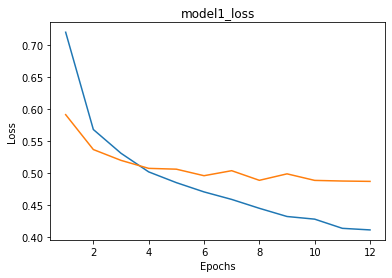

In [33]:
plt.plot(list(range(1, 13)), history1.history['loss'])
plt.plot(list(range(1, 13)), history1.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('photos/model1_loss.png')
plt.title("model1_loss")

plt.show()

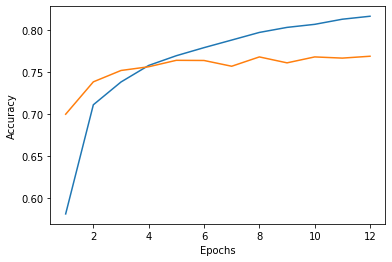

In [26]:
plt.plot(list(range(1, 13)), history1.history['accuracy'])
plt.plot(list(range(1, 13)), history1.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('photos/model1_accuracy.png')
plt.title("model1_accuracy")

plt.show()

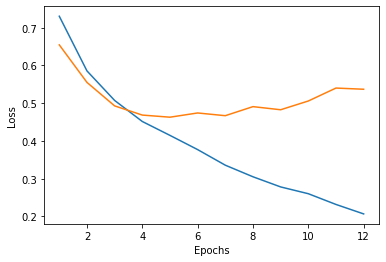

In [27]:
plt.plot(list(range(1, 13)), history2.history['loss'])
plt.plot(list(range(1, 13)), history2.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('photos/model2_loss.png')
plt.title("model2_loss")

plt.show()

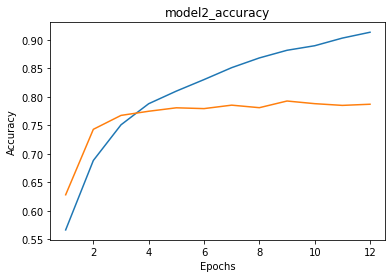

In [32]:
plt.plot(list(range(1, 13)), history2.history['accuracy'])
plt.plot(list(range(1, 13)), history2.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('photos/model2_accuracy.png')
plt.title("model2_accuracy")

plt.show()

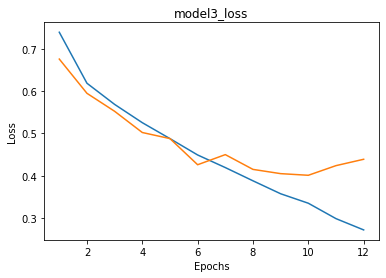

In [30]:
plt.plot(list(range(1, 13)), history3.history['loss'])
plt.plot(list(range(1, 13)), history3.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('photos/model3_loss.png')
plt.title("model3_loss")
plt.show()

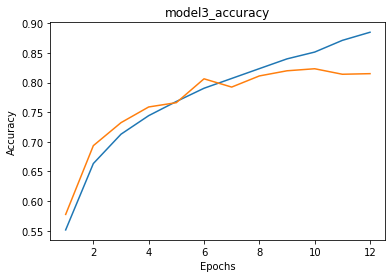

In [31]:
plt.plot(list(range(1, 13)), history3.history['accuracy'])
plt.plot(list(range(1, 13)), history3.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('photos/model3_accuracy.png')
plt.title("model3_accuracy")
plt.show()

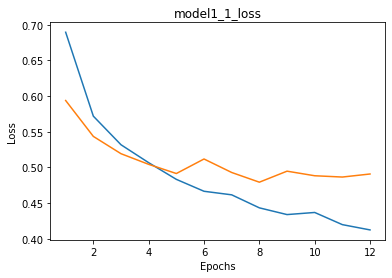

In [34]:
plt.plot(list(range(1, 13)), history1_1.history['loss'])
plt.plot(list(range(1, 13)), history1_1.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('photos/model1_1_loss.png')
plt.title("model1_1_loss")
plt.show()

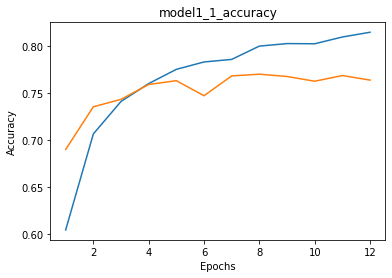

In [35]:
plt.plot(list(range(1, 13)), history1_1.history['accuracy'])
plt.plot(list(range(1, 13)), history1_1.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('photos/model1_1_accuracy.png')
plt.title("model1_1_accuracy")
plt.show()

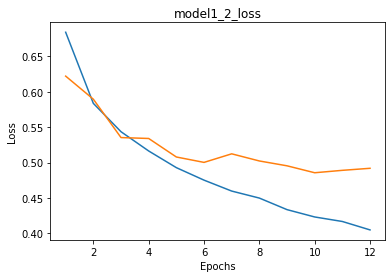

In [36]:
plt.plot(list(range(1, 13)), history1_2.history['loss'])
plt.plot(list(range(1, 13)), history1_2.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('photos/model1_2_loss.png')
plt.title("model1_2_loss")
plt.show()

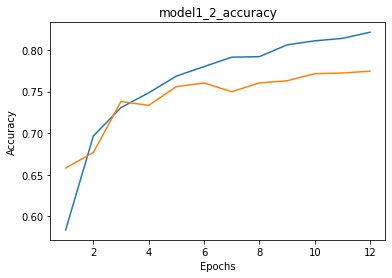

In [37]:
plt.plot(list(range(1, 13)), history1_2.history['accuracy'])
plt.plot(list(range(1, 13)), history1_2.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('photos/model1_2_accuracy.png')
plt.title("model1_2_accuracy")
plt.show()

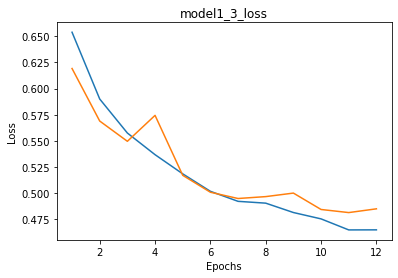

In [38]:
plt.plot(list(range(1, 13)), history1_3.history['loss'])
plt.plot(list(range(1, 13)), history1_3.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('photos/model1_3_loss.png')
plt.title("model1_3_loss")
plt.show()

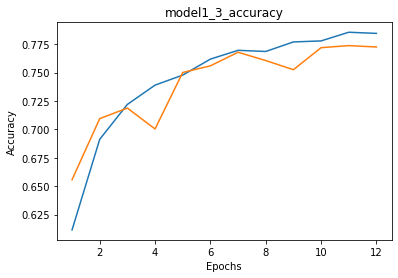

In [39]:
plt.plot(list(range(1, 13)), history1_3.history['accuracy'])
plt.plot(list(range(1, 13)), history1_3.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('photos/model1_3_accuracy.png')
plt.title("model1_3_accuracy")
plt.show()

Tensor Board

In [ ]:
%load_ext tensorboard

In [ ]:
for i in ["model1_1_accuracy.png", "model1_1_loss.png",
          "model1_2_accuracy.png", "model1_2_loss.png",
          "model1_3_accuracy.png", "model1_3_loss.png",
          "model1_accuracy.png", "model1_loss.png",
          "model2_accuracy.png", "model2_loss.png",
          "model3_accuracy.png", "model3_loss.png"]:

    image = tf.io.read_file('photos\\'+i)
    image_tensor = tf.image.decode_png(image, channels=4)
    image_tensor = tf.expand_dims(image_tensor, 0)

    # Create a TensorFlow summary writer
    log_dir = 'logs'
    summary_writer = tf.summary.create_file_writer(log_dir)
    with summary_writer.as_default():
        tf.summary.image('Training Plot', image_tensor, step=0)


Отже, в нашому випадку, ці дві більш складні моделі (з більшим числом параметрів), з дропаутами та нормалізацією за міні-батчами дають доволі гарну точніть, хоча їх тренувати було рази в 6-10 довше. Використання різних параметрів для pedding та strides трохи вплинули, але я їх тестував лише на найпростішій моделі, і не дуже багато змінених варіантів. Теж саме можно й сказати про розмірність ядра згортки.

transfer learning

In [49]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.layers import Dense, Flatten
from keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model_pre = Model(inputs=base_model.input, outputs=predictions)
model_pre.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_pre = model_pre.fit(
    x_train, y_train,
    batch_size=200, epochs=7,
    validation_split=0.2,
    validation_data=(x_test, y_test),
    verbose=1)


Epoch 1/7
99/99 [==============================] - 355s 4s/step - loss: 0.5514 - accuracy: 0.7132 - val_loss: 0.4865 - val_accuracy: 0.7538
Epoch 2/7
99/99 [==============================] - 329s 3s/step - loss: 0.4778 - accuracy: 0.7654 - val_loss: 0.4584 - val_accuracy: 0.7805
Epoch 3/7
99/99 [==============================] - 351s 4s/step - loss: 0.4612 - accuracy: 0.7779 - val_loss: 0.4485 - val_accuracy: 0.7853
Epoch 4/7
99/99 [==============================] - 364s 4s/step - loss: 0.4495 - accuracy: 0.7822 - val_loss: 0.4429 - val_accuracy: 0.7886
Epoch 5/7
99/99 [==============================] - 393s 4s/step - loss: 0.4353 - accuracy: 0.7943 - val_loss: 0.4464 - val_accuracy: 0.7813
Epoch 6/7
99/99 [==============================] - 390s 4s/step - loss: 0.4230 - accuracy: 0.8007 - val_loss: 0.4448 - val_accuracy: 0.7894
Epoch 7/7
99/99 [==============================] - 349s 4s/step - loss: 0.4127 - accuracy: 0.8045 - val_loss: 0.4351 - val_accuracy: 0.7916


In [50]:
model_pre.save("model_pre.h5")

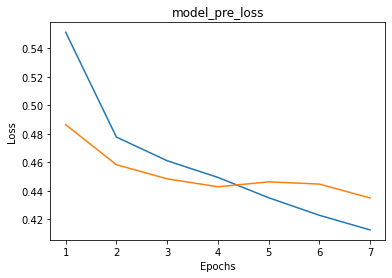

In [59]:
plt.plot(list(range(1, 8)), history_pre.history['loss'])
plt.plot(list(range(1, 8)), history_pre.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('photos/model_pre_loss.png')
plt.title("model_pre_loss")
plt.show()

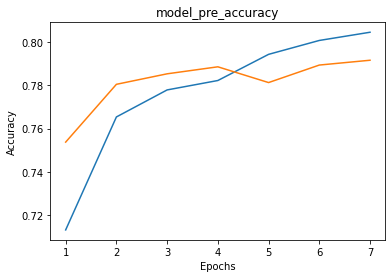

In [61]:
plt.plot(list(range(1, 8)), history_pre.history['accuracy'])
plt.plot(list(range(1, 8)), history_pre.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('photos/model_pre_accuracy.png')
plt.title("model_pre_accuracy")
plt.show()

І тепер класифікуємо одне фото з усіма моделями.

In [63]:
y_test[0]

array([0., 1.], dtype=float32)

In [70]:
models: list[tuple[any, str]] = [
    (model1, 'model1'), (model2, 'model2'), (model3, 'model3'),
    (model1_1, 'model1_1'), (model1_2, 'model1_2'),
    (model1_3, 'model1_3'), (model_pre, 'model_pre')
]
for model in models:
    x = model[0].predict(x_test[2:3], verbose=0)
    print(f"({x[0][0]}, {x[0][1]}), where model is {model[1]}")


(0.1043999046087265, 0.8956001400947571), where model is model1
(0.005668241530656815, 0.9943317174911499), where model is model2
(0.02098536305129528, 0.9790146946907043), where model is model3
(0.12360690534114838, 0.8763931393623352), where model is model1_1
(0.03568160533905029, 0.9643184542655945), where model is model1_2
(0.12990330159664154, 0.870096743106842), where model is model1_3
(0.09399629384279251, 0.9060037136077881), where model is model_pre


А саме зображення виглядає наступним чином:

Image shape: (50, 50, 3)


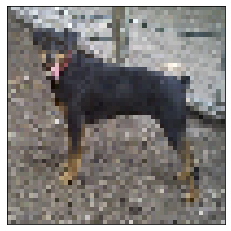

In [80]:
img = x_test[2]
print('Image shape:', img.shape)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

plt.show()

Як ми і моделі бачимо, це дійсно пес.